# Clustering
## From "Exercises in Clustering.ipynb" February 21, 2025
(use venv_requirements.txt)

The hand-in exercises for this topic is Exercise 1 from the notebook “Exercises in
Clustering.ipynb”.

## Exercise 1

In this exercise, we will use a bike sharing dataset. The dataset contains coordinates of bike sharing stations in New York given as longitude and latitude values. (its actually Washington D.C.)

The dataset is am example dataset from the book ["Introduction to R for Business Intelligence"](https://jgendron.github.io/com.packtpub.intro.r.bi/), Packt Publishing Ltd., 2016, by Jay Gendron. The dataset is downloadable from Github [here](https://github.com/jgendron/com.packtpub.intro.r.bi/tree/master/Chapter5-ClusteringAnalysis/data), but is also available on Moodle as "Ch5_bike_station_locations.csv".

Answer the following questions:
1. Apply K-Means clustering to the dataset. Try out different values for K and use the Elbow method to find the best (or a sensible) K.
2. Visualize the K-Means clustering result for the best K.
3. Apply Agglomerative clustering to the dataset. Draw the Dendrogram and use it to find the best (or a sensible) number of clusters.
4. Generate this number of clusters with Agglomerative clustering and visualize the clustering.
5. Apply DBSCAN clustering to the dataset. Try out different values for "eps" and "min_samples" and choose the best values. (Hint: For "eps" you probably have to try out values around 0.01.)
6. Visual the final DBSCAN clustering you decided upon in 5.
7. Calculate the Silhouette scores for the three different "best clustering" you found with the three different methods. Also use Adjusted Rand Index to compare the best ones to each other.

# 1. Apply K-Means clustering to the dataset. Try out different values for K and use the Elbow method to find the best (or a sensible) K.

In [2]:
import numpy as np
import scipy.cluster.hierarchy as shc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import warnings

from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import DBSCAN


In [3]:
#reading in the bike station location data set
df = pd.read_csv('..\\data\\Ch5_bike_station_locations.csv')
df

,latitude,longitude
0,38.956590,-76.993437
1,38.905218,-77.001496
2,38.980858,-77.054722
3,38.902925,-76.929915
4,38.949498,-77.093620
...,...,...
239,38.965620,-77.060719
240,38.880730,-76.993533
241,38.924690,-76.978702
242,38.869303,-76.968034


In [14]:
# Scale the data set between 0 and 1 - we want to maintain the relative scale of features latitiude and longitude
# - alt. we could perform Z-score Normalization or no normalization
minMaxScaler = MinMaxScaler()
df_scaled_mm = pd.DataFrame(minMaxScaler.fit_transform(df), columns=df.columns)

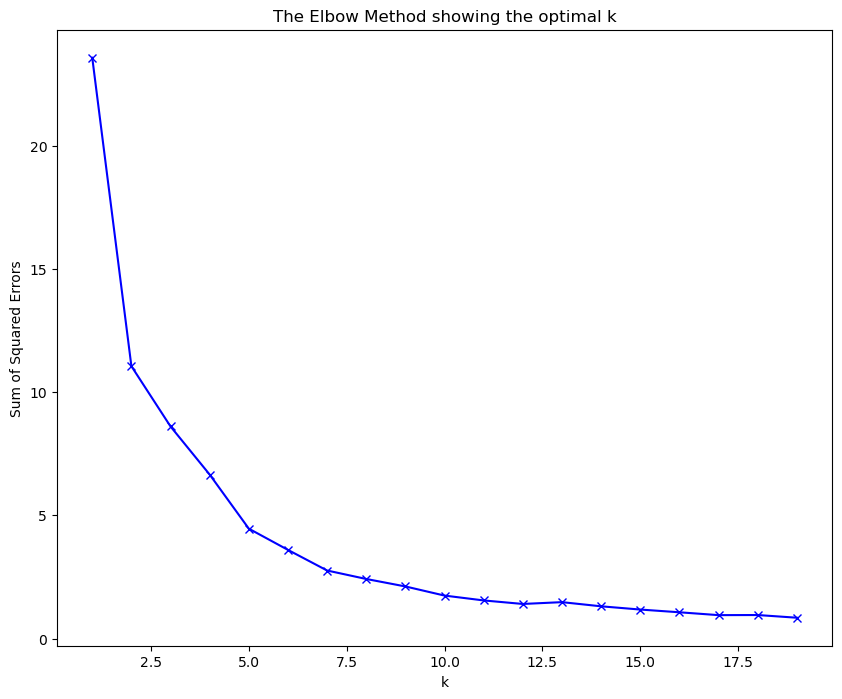

In [15]:
#ive got no idea why errors pop up, so we sush them for now
warnings.filterwarnings('ignore')

#we will use this to store the errors, which will be our points in the plot below
errors = []

#Define an arbitrary range of clusters, K
K = range(1, 20)


for k in K:
    #init KMeans model for each k in K
    kmeanModel = KMeans(n_clusters=k)
    # fit the model to the scaled data
    kmeanModel.fit(df_scaled_mm)

    #append the inertia value to SSE (euclidian distance between each data point and their assigned clusters centroid) 
    errors.append(kmeanModel.inertia_)

#plotting the Sum of Squared Errors
plt.figure(figsize=(10, 8))
plt.plot(K, errors, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Errors')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [26]:
#looping through our SSE values, just for display
for k in range(1, len(errors) + 1):
    print(f'K={k}: {errors[k-1]}')

K=1: 23.561557635729613
K=2: 11.049158484040383
K=3: 8.603491259012394
K=4: 6.6521542641882245
K=5: 4.4585916347784575
K=6: 3.5968280081231105
K=7: 2.760578112293598
K=8: 2.417374305150973
K=9: 2.1143499208492678
K=10: 1.7439406739230612
K=11: 1.5472544604726406
K=12: 1.4038877837101775
K=13: 1.4775267397325706
K=14: 1.3090502601779979
K=15: 1.1774030223433478
K=16: 1.0666922031308799
K=17: 0.9506378460408536
K=18: 0.9550201816136052
K=19: 0.8457608013063549


We go with K=5, cause improvements seem less pronounced after 6, but we wont be overfitting too much. 
but 4 and 6 could be good to test too - however we go with K=5

# 2. Visualize the K-Means clustering result for the best K.


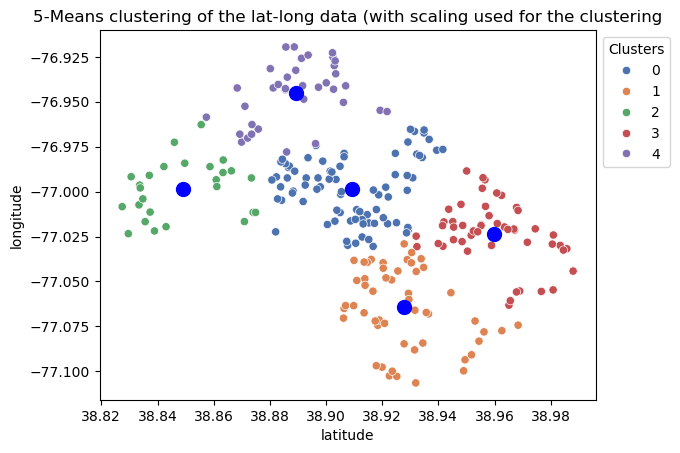

In [33]:
#init the KMeans model for 5 clusters
kmeans_scaled5 = KMeans(n_clusters=5)

#fiting it to the scaled data
kmeans_scaled5.fit(df_scaled_mm)

# add cluster labels to the original DataFrame 
df["5MeansClusterLabel"] = kmeans_scaled5.labels_

# Inverse transforming centroids back into the orignal values (otherwise they'd just be 0-1)
centroids5 = minMaxScaler.inverse_transform(kmeans_scaled5.cluster_centers_)


sns.scatterplot(data = df, x = "latitude", y = "longitude", hue = "5MeansClusterLabel", palette="deep")
plt.scatter(x = centroids5[:,0], y = centroids5[:,1], color='blue', s = 100)
plt.title("5-Means clustering of the lat-long data (with scaling used for the clustering")
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# 3. Apply Agglomerative clustering to the dataset. Draw the Dendrogram and use it to find the best (or a sensible) number of clusters.


In [209]:
#Making a func that takes a number of clusters, and type of linkage
def aggClustering(n, link):
    # init and fit
    agg = AgglomerativeClustering(n_clusters=n, linkage=link)
    agg.fit(df_scaled_mm)

    #add cluster label to origianl df for each column
    df["aggCluster{0}".format(n)] = agg.labels_

    #calc cluster centroids using aggCluster label to group individual point  
    centroids = df.groupby(f"aggCluster{n}").mean()
    
    #plotting
    plt.figure(figsize=(8, 6))  
    sns.scatterplot(data = df, x = "latitude", y = "longitude", hue = "aggCluster{0}".format(n), palette="deep")
    plt.scatter(centroids["latitude"], centroids["longitude"], color='red', s=100, label='Centroids')
    plt.title(f'Agglomative clustering of bike  data with {n} clusters and of type {link}')
    plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()
    return agg

In [20]:
# no way in hell I am scrolling through all these to visually inspect 9*4 different plots
# There's got to be a better way!!

# for cn in range(9, 0, -1):
#     aggClustering(cn, 'ward')
#     aggClustering(cn, 'complete')
#     aggClustering(cn, 'average')
#     aggClustering(cn, 'single')

In [ ]:
# So the better way is looking at four different types of dendograms, one for each linkage method
def plotDendo(df,link):
    plt.figure(figsize=(10, 7))
    plt.title(f"{link} Dendogram")
    shc.dendrogram(shc.linkage(df, method=link))
    plt.show()


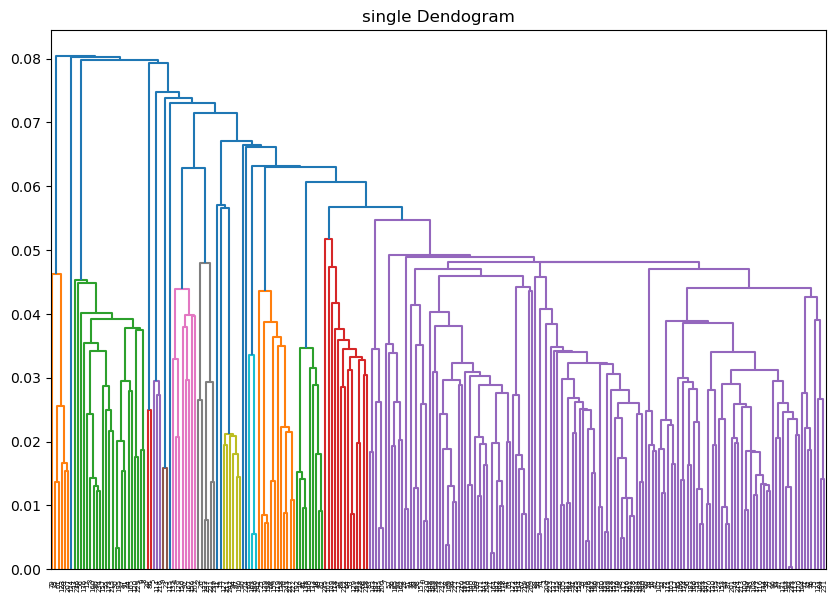

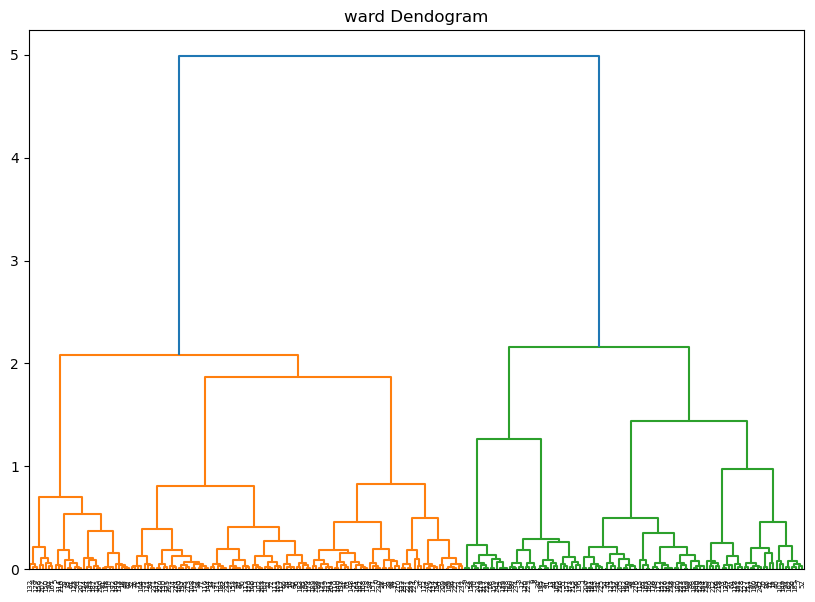

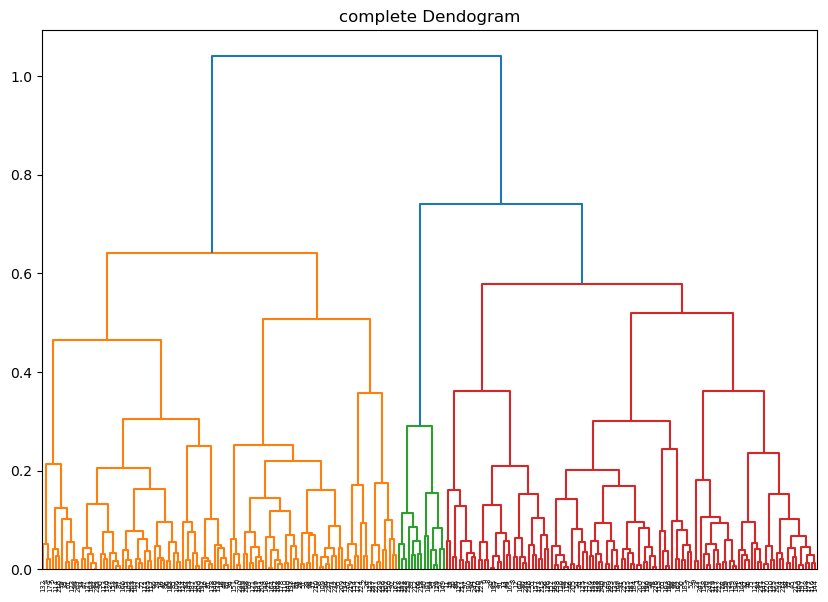

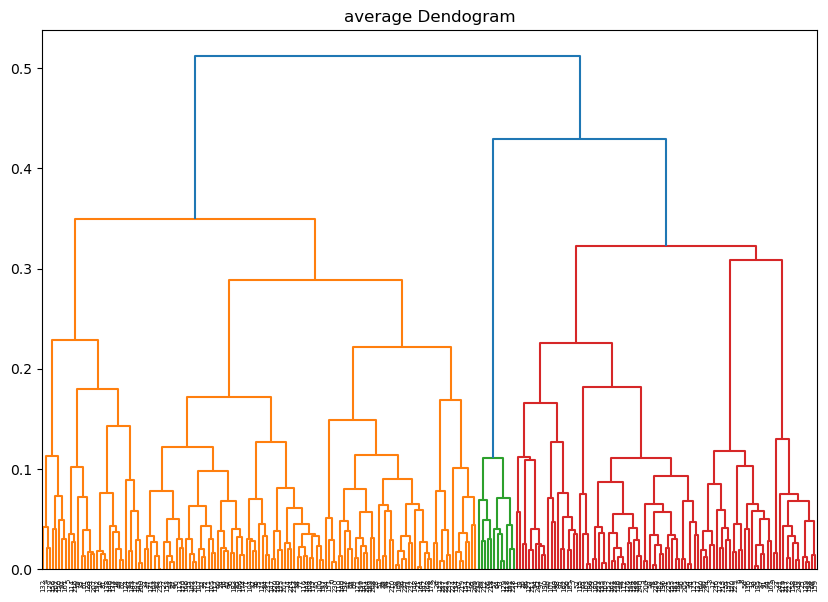

In [ ]:
plotDendo(df_scaled_mm, 'single')
plotDendo(df_scaled_mm, 'ward')
plotDendo(df_scaled_mm, 'complete')
plotDendo(df_scaled_mm, 'average')

Single Dendogram has less distinct vertical drops and stands out as not having any clear clusters we can cut at. the Single linkage is sensitive to outliers, which we see in effect.

Our Ward Dendogram shows two well defnined clusters and significant and clear vertical drops. The method is ideal for internally compact and well defined clusters. the largest drop happen between 2.5 and 5.
but that would just mean having two clusters. 

Complete linkage considers the maximum distance between clusters, making it useful for compact clusters. Based on visual inspection of the Complete dendogram the longest vertical drop spans around 0.1 to 0.43. (including the green cluster). I will use this and decide to use 3 clusters, as there obviously are 2 big clusters, and 1 smaller group that seems to be too far from the other two. 
Average Dendogram looks to be a middle ground between Single and Complete in this case. Ideal when you want the average distance between clusters, this also indicates the clusters is 3-4.


Conclusion: Complete linkage, looks good. cut off at height 0.7 on linkage = Complete i.e gettin the 3 major branches  <br>
now lets:


## 4. Generate this number of clusters with Agglomerative clustering and visualize the clustering.


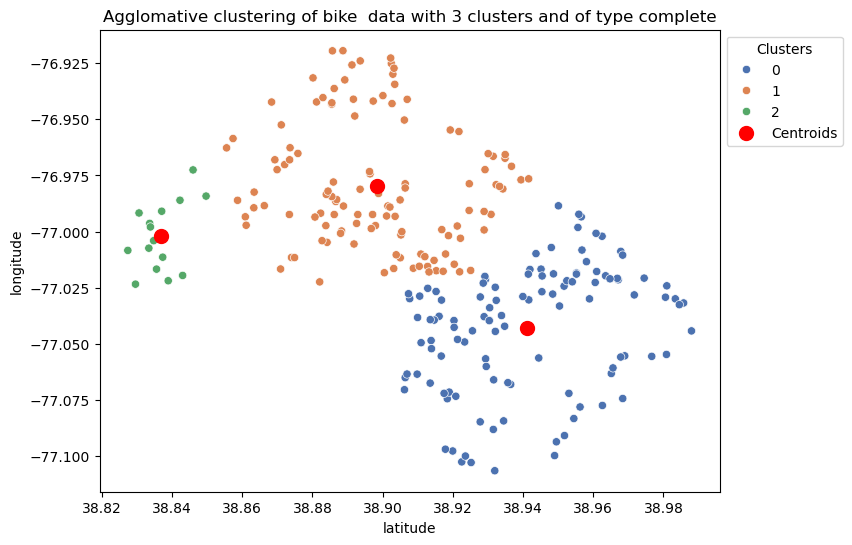

In [212]:
#using our method from earlier
aggmodel = aggClustering(3, "complete")

## 5. Apply DBSCAN clustering to the dataset. Try out different values for "eps" and "min_samples" and choose the best values. (Hint: For "eps" you probably have to try out values around 0.01.)

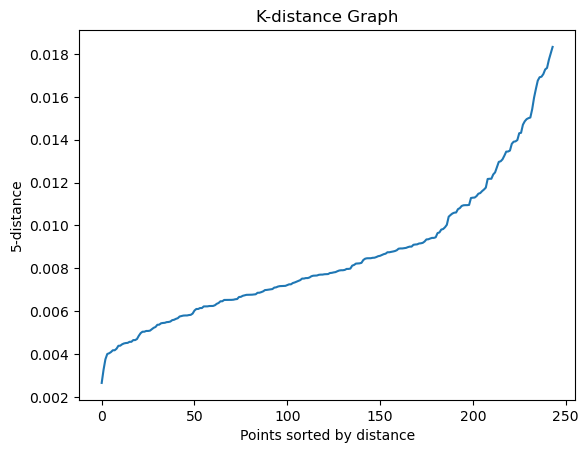

In [ ]:
from sklearn.neighbors import NearestNeighbors
#load data and convert  into 2D array
df = pd.read_csv('..\\data\\Ch5_bike_station_locations.csv')
cordinates = df[['latitude', 'longitude']].to_numpy()



## Quuuuick interpretation of the output below:
print out is cluster labels, for each loop ran.

So for each run, cluster labels are printed out. Each number represents a unique cluster. Points which the same number indicates that they below to the same cluster.
-1 is noise i.e not given a cluster.

For our business case we say that:
- We dont mind a couple of outliers.
- We want clusters close together
- somewhat compact clusters
- and a low amount of clusters.

based on the DBScan clustering results generated - we like:
Cluster memberships run 6 for eps: 0.012 and min_samples: 6:Number of outliers identified: 20
Cluster memberships run 7 for eps: 0.012 and min_samples: 7:Number of outliers identified: 40

We would go with run 6 for eps: 0.012 and min_samples: 6 as that has generally low amounts of outliers and does also keep the amount of clusters low.
This allow us to capture as many data points as possible while having some detailed insight into the data.


To be honest, I dont find the amount of time I spent looking for good parameters was worth it, as the result is barely good enough to cluster the data.
But now we tried it.


Cluster memberships run 1 for eps: 0.012 and min_samples: 6:
[ 0  0  4  1  5 -1  1  0  1 -1  0 -1  1  1  0  0  0  0  0  0 -1  0  0 -1
  0  0  4  0  0  0  1  0  0  0  0  3  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0  0  2  0  1  1  2  0  0  0  3  0  0  2 -1  2  0  0  0  0  0
  0  0  0  0  0  0  0  3  1  0  0  0  0  0 -1  0  0  2  0  1  5  0  0  0
  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0  4  3 -1  0  0  0  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0 -1
  0 -1  0  0  0 -1  5  0  0  0  0  0 -1  1  0  0  1  0  0  0  0  1  0  5
  0  0  0  0  0  1  0  0  0  0  0  5  0  0  0  0  0  0  0 -1  0  0  0  2
  0  0  0  1  0  0  0  0 -1  0  5  0  0  0  0  3  0  0  0  0  2  0  0  1
 -1  0  2  0  0  4  0  0 -1  0  0  0  2  1  0  0  0  0  1  2  1  4  0  4
  0  0  0  0]

Number of outliers identified: 20


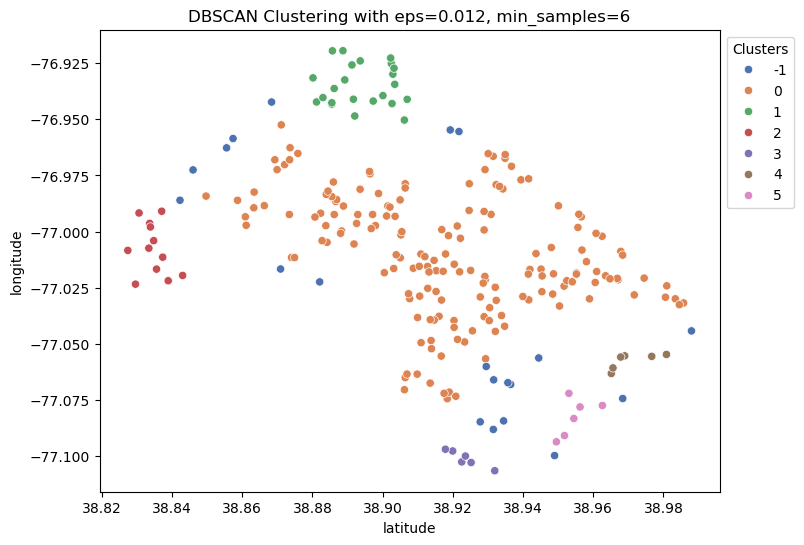

Cluster memberships run 2 for eps: 0.012 and min_samples: 7:
[ 0  0 -1  1 -1 -1  1  2  1 -1  0 -1  1  1  0  0  0  0  0  4 -1  0  0 -1
  0  0 -1  0  0  0  1  0  0  0  0 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  2  0  2  3  0  1  1 -1  0  0  0 -1  0  0 -1 -1  3  0  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0  3  0  1 -1  2  4  0
  0  4  0 -1  0  2  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  3  0
  1  0 -1 -1 -1  0  0  4  0  3  0  0 -1  0  0  0  1  0  0  0  0  0  0 -1
  0 -1  0  0  0 -1 -1  0  0  0  0  0 -1  1  0  0  1  0  2  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  2  0 -1  0  0  4  3
  0  0  0  1  0  0  0  0 -1  0 -1  0  0  0  0 -1  0  0  0  4  3  0  0  1
 -1  0  3  0  0 -1  0  0 -1  0  0  0  3  1  0  0  0  0  1  3  1 -1  0 -1
  0  0  4  0]

Number of outliers identified: 40


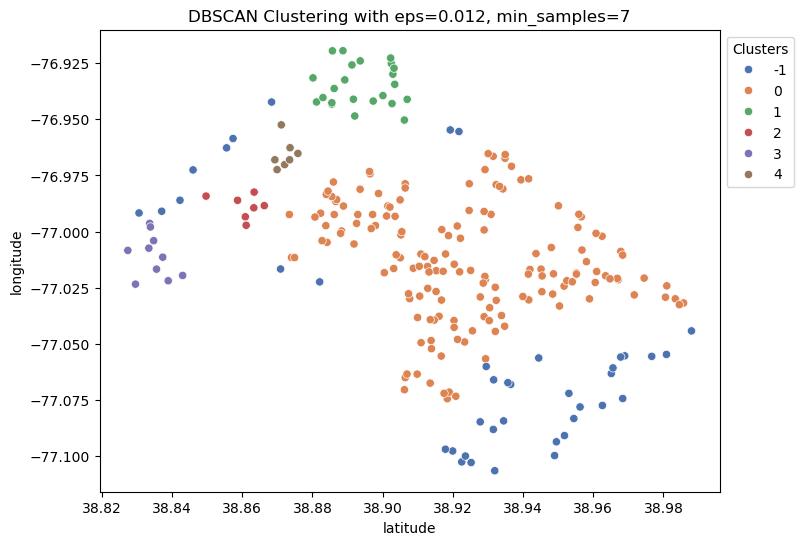

Cluster memberships run 3 for eps: 0.012 and min_samples: 8:
[ 0  0 -1  1 -1 -1  1 -1  1 -1  3 -1  1  1  0  0  0  0  3 -1 -1  0  0 -1
  0  2 -1  0  0  0  1  0  0  0  0 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  3 -1  0 -1 -1  0  1  1 -1  0  0  0 -1  3  0 -1 -1 -1 -1  2  0  2  0
  0  0  0  0  0  0  0 -1  1  3  0  0  0  0 -1  0  0 -1  0  1 -1 -1 -1  0
  0 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0 -1  2
  1  0 -1 -1 -1  0  0 -1  0 -1  0  0 -1  3  0  0  1  0  3  2  0  0  0 -1
  0 -1  3  0  0 -1 -1  0  0  0  0  0 -1  1  2  2  1  0 -1  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0 -1  0 -1  0  0 -1 -1
  3  0  0  1  0  0  2  0 -1  0 -1  0  0  0  0 -1  0  0  0 -1 -1  0  0  1
 -1  2 -1 -1  0 -1  2  0 -1  0  0  0 -1  1  0  0  0  0  1 -1  1 -1  0 -1
  0  2 -1  2]

Number of outliers identified: 66


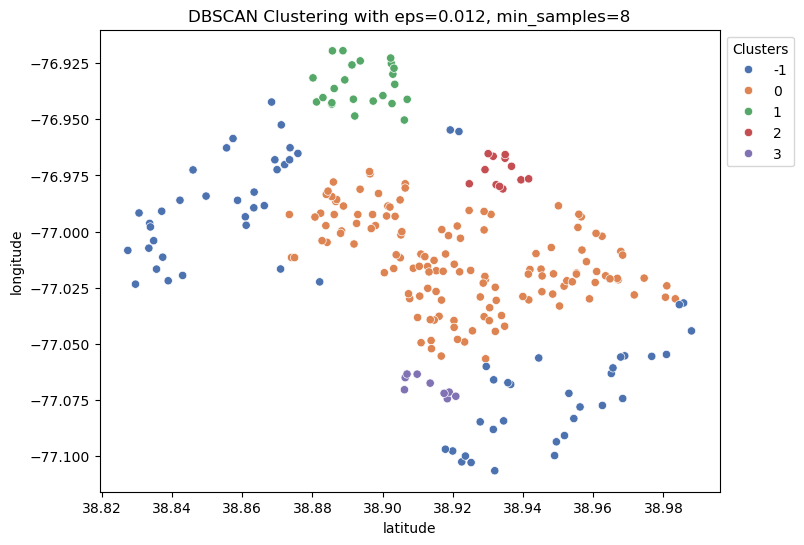

Cluster memberships run 4 for eps: 0.012 and min_samples: 9:
[-1  0 -1  1 -1 -1  1 -1  1 -1  3 -1  1  1  0  0  0  0  3 -1 -1  0  0 -1
  0  2 -1  0  0  0  1  0  0  0 -1 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  3 -1  0 -1 -1  0  1  1 -1  0  0  0 -1  3  0 -1 -1 -1 -1  2  0  2  0
  0  0  0  0  0  0  0 -1  1  3  0  0  2  0 -1  0  0 -1  0  1 -1 -1 -1  0
  0 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0 -1  2
  1 -1 -1 -1 -1  0  0 -1  0 -1  0  0 -1  3  0  0  1  0  3  2  0  0  0 -1
  0 -1  3  0  0 -1 -1  0  0  0  0  0 -1  1  2  2  1  0 -1  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0 -1  0 -1  0  0 -1 -1
  3  0  0  1  0  0  2  0 -1  0 -1  0  0  0  0 -1  0  0  0 -1 -1  0  0  1
 -1  2 -1 -1  0 -1  2  0 -1  0  0  0 -1  1 -1  2  0  0  1 -1 -1 -1  0 -1
  0  2 -1  2]

Number of outliers identified: 71


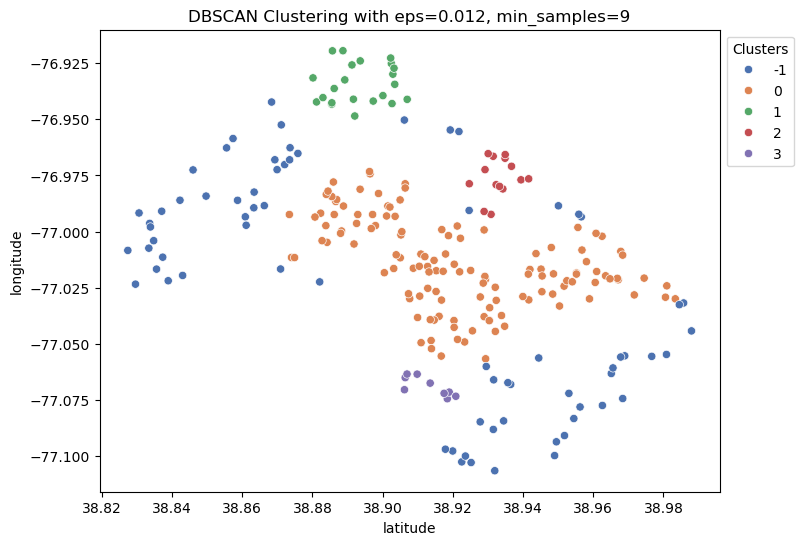

Cluster memberships run 5 for eps: 0.013 and min_samples: 6:
[ 0  0  4  1  5 -1  1  0  1 -1  0  1  1  1  0  0  0  0  0  0 -1  0  0  0
  0  0  4  0  0  0  1  0  0  0  0  3  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0  0  2  0  1  1  2  0  0  0  3  0  0  2  0  2  0  0  0  0  0
  0  0  0  0  0  0  0  3  1  0  0  0  0  0 -1  0  0  2  0  1  5  0  0  0
  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  2  0
  1  0  4  3 -1  0  0  0  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0 -1  5  0  0  0  0  0 -1  1  0  0  1  0  0  0  0  1  0  5
  0  0  0  0  0  1  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  2
  0  0  0  1  0  0  0  0  0  0  5  0  0  0  0  3  0  0  0  0  2  0  0  1
 -1  0  2  0  0  4  0  0  0  0  0  0  2  1  0  0  0  0  1  2  1  4  0  4
  0  0  0  0]

Number of outliers identified: 11


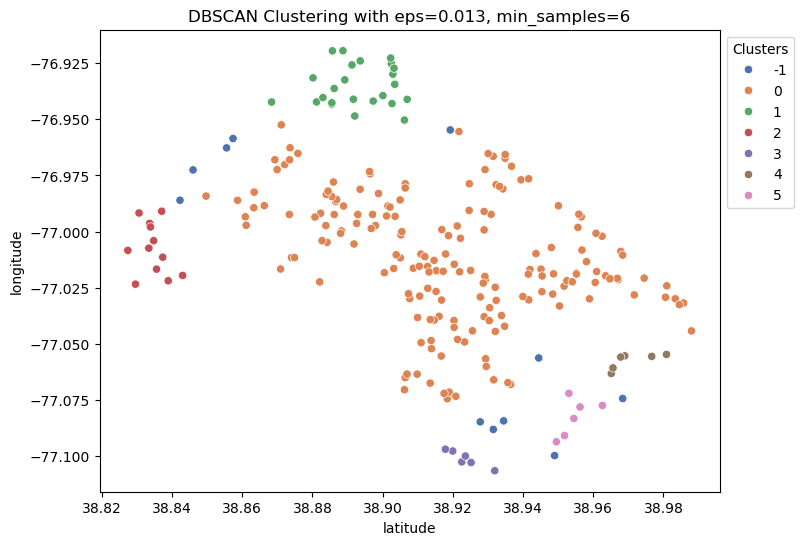

Cluster memberships run 6 for eps: 0.013 and min_samples: 7:
[ 0  0 -1  1 -1 -1  1  0  1 -1  0  1  1  1  0  0  0  0  0  3 -1  0  0  0
  0  0 -1  0  0  0  1  0  0  0  0 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0  0  2  0  1  1  2  0  0  0 -1  0  0  2 -1  2  0  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0  2  0  1 -1  0  3  0
  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0 -1 -1 -1  0  0  3  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0 -1  0  0  0 -1 -1  0  0  0  0  0 -1  1  0  0  1  0  0  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  3  2
  0  0  0  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  3  2  0  0  1
 -1  0  2  0  0 -1  0  0 -1  0  0  0  2  1  0  0  0  0  1  2  1 -1  0 -1
  0  0  3  0]

Number of outliers identified: 33


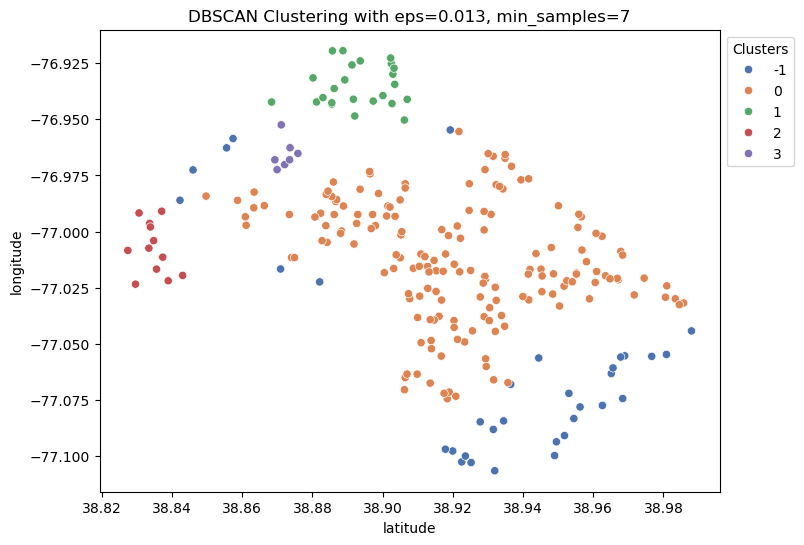

Cluster memberships run 7 for eps: 0.013 and min_samples: 8:
[ 0  0 -1  1 -1 -1  1 -1  1 -1  0  1  1  1  0  0  0  0  0 -1 -1  0  0 -1
  0  0 -1  0  0  0  1  0  0  0  0 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0 -1 -1  0  1  1 -1  0  0  0 -1  0  0 -1 -1  2 -1  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0  2  0  1 -1  0 -1  0
  0 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0 -1 -1 -1  0  0 -1  0 -1  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0 -1  0  0  0 -1 -1  0  0  0  0  0 -1  1  0  0  1  0 -1  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  2
  0  0  0  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0 -1  2  0  0  1
 -1  0  2 -1  0 -1  0  0 -1  0  0  0  2  1  0  0  0  0  1  2  1 -1  0 -1
  0  0 -1  0]

Number of outliers identified: 51


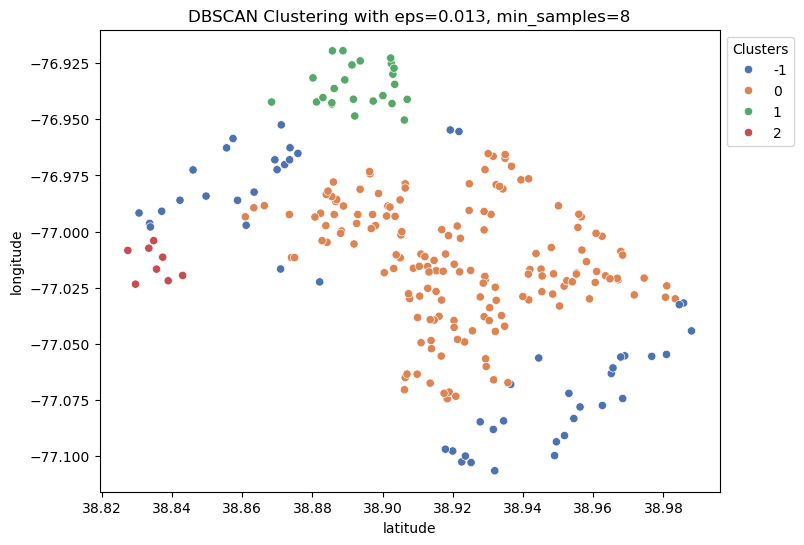

Cluster memberships run 8 for eps: 0.013 and min_samples: 9:
[ 0  0 -1  1 -1 -1  1 -1  1 -1  0  1  1  1  0  0  0  0  0 -1 -1  0  0 -1
  0  2 -1  0  0  0  1  0  0  0 -1 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0 -1  0 -1 -1  0  1  1 -1  0  0  0 -1  0  0 -1 -1 -1 -1  2  0  2  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0 -1  0  1 -1 -1 -1  0
  0 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0 -1  2
  1  0 -1 -1 -1  0  0 -1  0 -1  0  0 -1  0  0  0  1  0  0  2  0  0  0  0
  0 -1  0  0  0 -1 -1  0  0  0  0  0 -1  1  2  2  1  0 -1  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0 -1  0 -1  0  0 -1 -1
  0  0  0  1  0  0  2  0 -1  0 -1  0  0  0  0 -1  0  0  0 -1 -1  0  0  1
 -1  2 -1 -1  0 -1  2  0 -1  0  0  0 -1  1  0  0  0  0  1 -1  1 -1  0 -1
  0  0 -1  2]

Number of outliers identified: 65


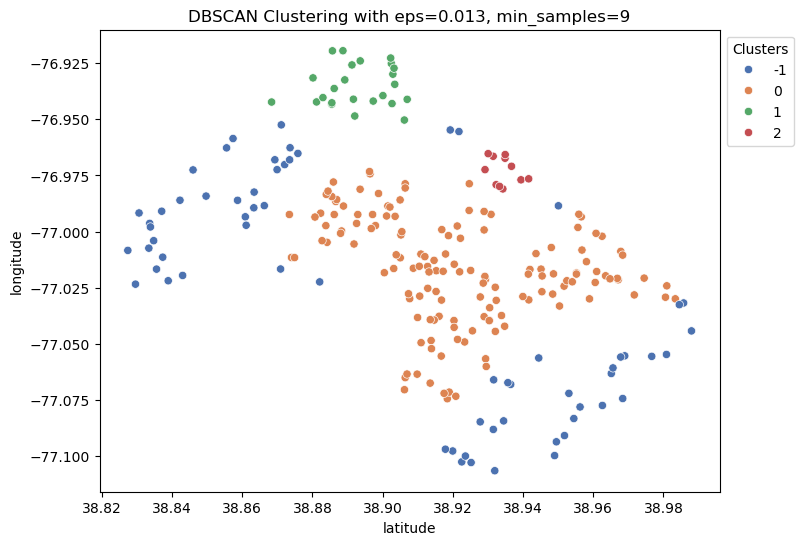

Cluster memberships run 9 for eps: 0.014 and min_samples: 6:
[ 0  0  2  1  4  0  1  0  1  1  0  1  1  1  0  0  0  0  0  0 -1  0  0  0
  0  0  2  0  0  0  1  0  0  0  0  5  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0  0  3  0  1  1  3  0  0  0  5  0  0  3  0  3  0  0  0  0  0
  0  0  0  0  0  0  0  5  1  0  0  0  0  0 -1  0  0  3  0  1  4  0  0  0
  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  3  0
  1  0  2  5 -1  0  0  0  0  3  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  3  4  0  0  0  0  0  2  1  0  0  1  0  0  0  0  1  0  4
  0  0  0  0  0  1  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  3
  0  0  0  1  0  0  0  0  0  0  4  0  0  0  0  5  0  0  0  0  3  0  0  1
 -1  0  3  0  0  2  0  0  0  0  0  0  3  1  0  0  0  0  1  3  1  2  0  2
  0  0  0  0]

Number of outliers identified: 7


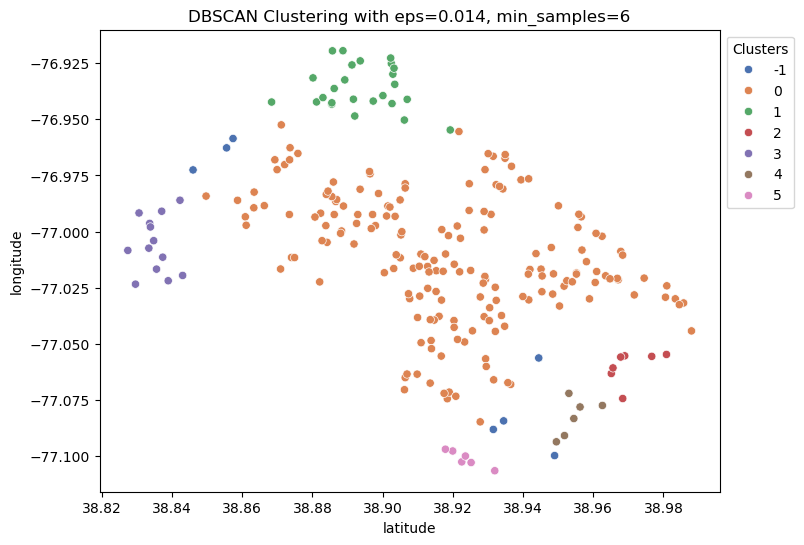

Cluster memberships run 10 for eps: 0.014 and min_samples: 7:
[ 0  0 -1  1 -1  0  1  0  1 -1  0  1  1  1  0  0  0  0  0  0 -1  0  0  0
  0  0 -1  0  0  0  1  0  0  0  0 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0  0  2  0  1  1  2  0  0  0 -1  0  0  2 -1  2  0  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0  2  0  1 -1  0  0  0
  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0 -1 -1 -1  0  0  0  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  2 -1  0  0  0  0  0 -1  1  0  0  1  0  0  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  2
  0  0  0  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  2  0  0  1
 -1  0  2  0  0 -1  0  0  0  0  0  0  2  1  0  0  0  0  1  2  1 -1  0 -1
  0  0  0  0]

Number of outliers identified: 29


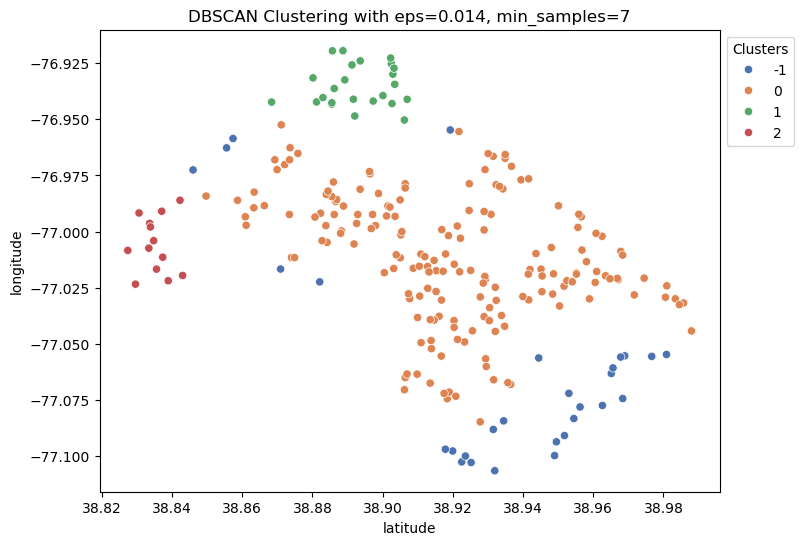

Cluster memberships run 11 for eps: 0.014 and min_samples: 8:
[ 0  0 -1  1 -1  0  1 -1  1 -1  0  1  1  1  0  0  0  0  0 -1 -1  0  0 -1
  0  0 -1  0  0  0  1  0  0  0  0 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0 -1  2  0  1  1  2  0  0  0 -1  0  0  2 -1  2 -1  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0  2  0  1 -1  0 -1  0
  0 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0 -1 -1 -1  0  0 -1  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  2 -1  0  0  0  0  0 -1  1  0  0  1  0  0  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  2
  0  0  0  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0 -1  2  0  0  1
 -1  0  2  0  0 -1  0  0 -1  0  0  0  2  1  0  0  0  0  1  2  1 -1  0 -1
  0  0 -1  0]

Number of outliers identified: 42


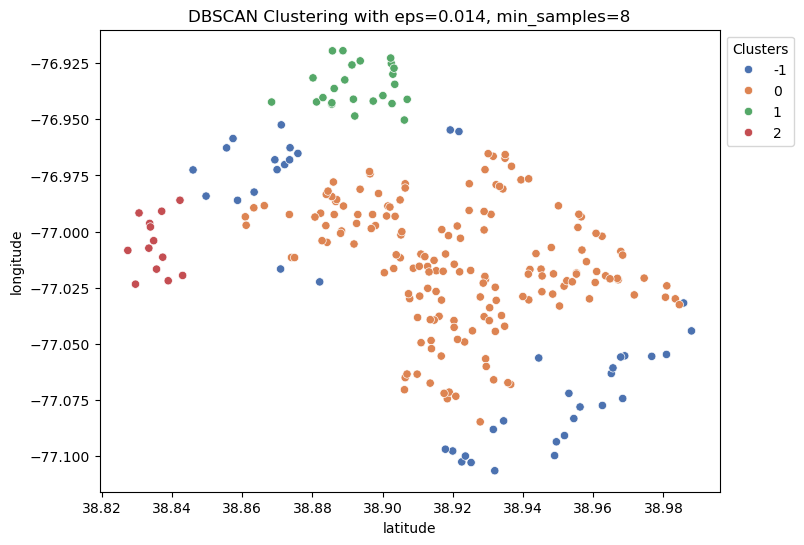

Cluster memberships run 12 for eps: 0.014 and min_samples: 9:
[ 0  0 -1  1 -1 -1  1 -1  1 -1  0  1  1  1  0  0  0  0  0 -1 -1  0  0 -1
  0  0 -1  0  0  0  1  0  0  0 -1 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0 -1  2  0  1  1  2  0  0  0 -1  0  0  2 -1  2 -1  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0 -1  0  1 -1  0 -1  0
  0 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0 -1 -1 -1  0  0 -1  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0 -1 -1  0  0  0  0  0 -1  1  0  0  1  0  0  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  2
  0  0  0  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0 -1 -1  0  0  1
 -1  0  2  0  0 -1  0  0 -1  0  0  0  2  1  0  0  0  0  1 -1  1 -1  0 -1
  0  0 -1  0]

Number of outliers identified: 48


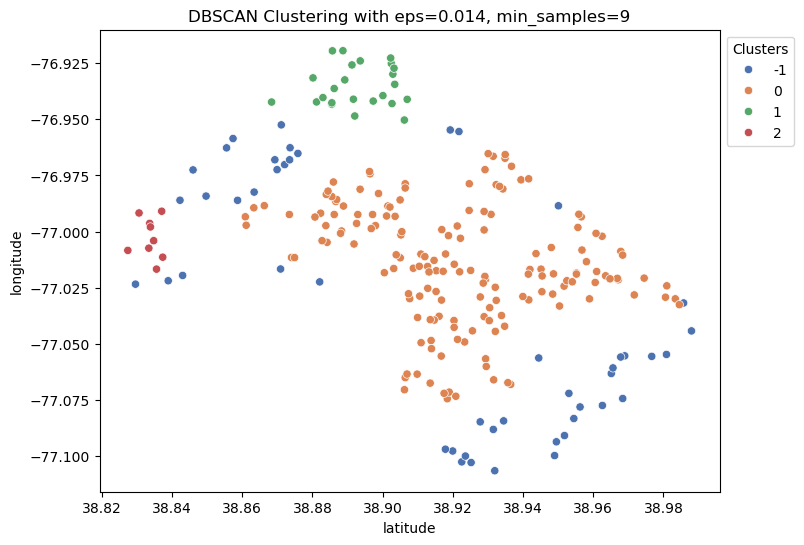

Cluster memberships run 13 for eps: 0.015 and min_samples: 6:
[ 0  0  2  1  2  0  1  0  1  1  0  1  1  1  0  0  0  0  0  0  0  0  0  0
  0  0  2  0  0  0  1  0  0  0  0  3  0  1  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  1  1  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  3  1  0  0  0  0  0 -1  0  0  0  0  1  2  0  0  0
  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0
  1  0  2  3  0  0  0  0  0  0  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  2  0  0  0  0  0  2  1  0  0  1  0  0  0  0  1  0  2
  0  0  0  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  2  0  0  0  0  3  0  0  0  0  0  0  0  1
  3  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  1  0  1  2  0  2
  0  0  0  0]

Number of outliers identified: 3


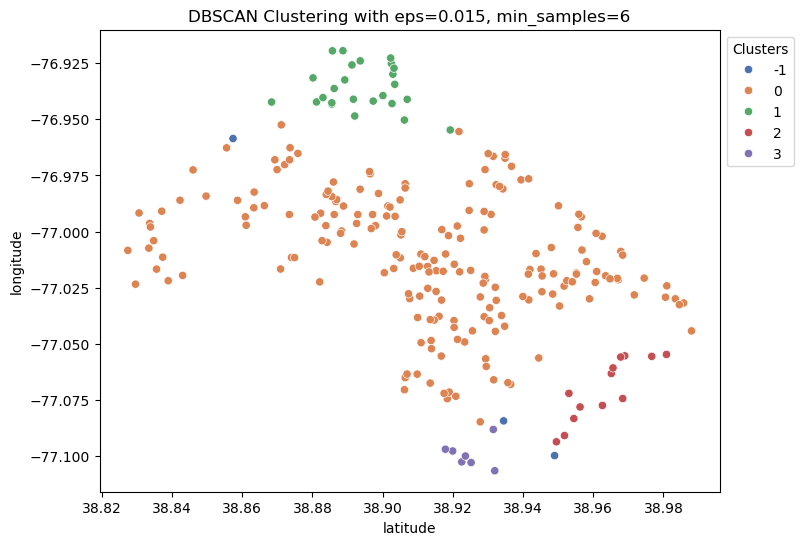

Cluster memberships run 14 for eps: 0.015 and min_samples: 7:
[ 0  0 -1  1 -1  0  1  0  1  1  0  1  1  1  0  0  0  0  0  0  0  0  0  0
  0  0  3  0  0  0  1  0  0  0  0  2  0  1  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  0  0  1  1  0  0  0  0  2  0  0  0 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  2  1  0  0  0  0  0 -1  0  0  0  0  1 -1  0  0  0
  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0
  1  0  3  2 -1  0  0  0  0  0  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  3  0  0  0  0  0  3  1  0  0  1  0  0  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  3  0  0  0  0  2  0  0  0  0  0  0  0  1
  2  0  0  0  0  3  0  0  0  0  0  0  0  1  0  0  0  0  1  0  1  3  0  3
  0  0  0  0]

Number of outliers identified: 11


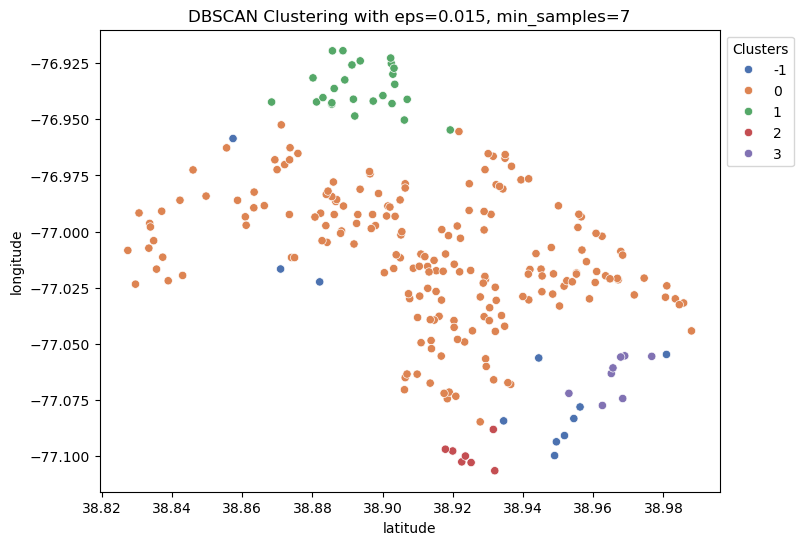

Cluster memberships run 15 for eps: 0.015 and min_samples: 8:
[ 0  0 -1  1 -1  0  1  0  1 -1  0  1  1  1  0  0  0  0  0  1 -1  0  0  0
  0  0  3  0  0  0  1  0  0  0  0 -1  0  1  0  0  0  0  0  0  1  0  0  0
  0  0  0  0  0  2  0  1  1  0  0  0  0 -1  0  0  2 -1  2  0  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0  2  0  1 -1  0  0  0
  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0  3 -1 -1  0  0 -1  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  3  0  0  0  0  0  3  1  0  0  1  0  0  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  2
  0  0  0  1  0  0  0  0  0  0  3  0  0  0  0 -1  0  0  0 -1  2  0  0  1
 -1  0  2  0  0  3  0  0 -1  0  0  0  2  1  0  0  0  0  1  2  1  3  0  3
  0  0 -1  0]

Number of outliers identified: 26


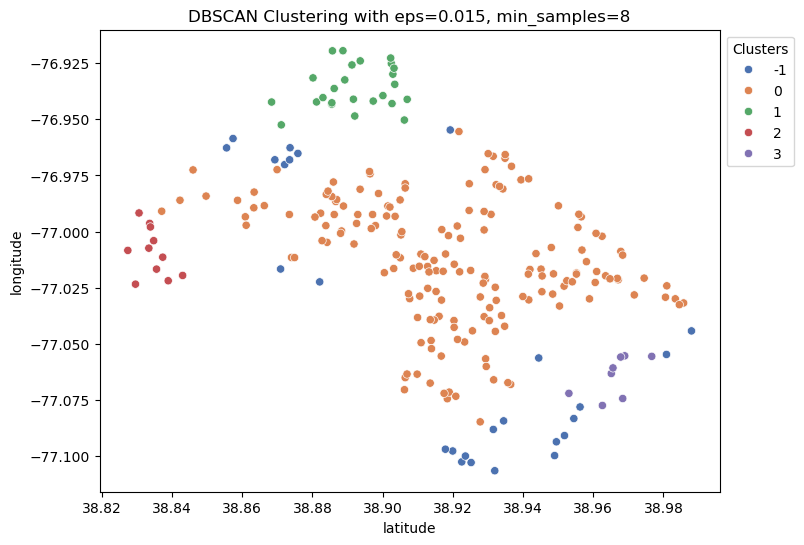

Cluster memberships run 16 for eps: 0.015 and min_samples: 9:
[ 0  0 -1  1 -1  0  1  0  1 -1  0  1  1  1  0  0  0  0  0  1 -1  0  0  0
  0  0 -1  0  0  0  1  0  0  0  0 -1  0  1  0  0 -1  0  0  0  1  0  0  0
  0  0  0  0  0  2  0  1  1  2  0  0  0 -1  0  0  2 -1  2  0  0  0  0  0
  0  0  0  0  0  0  0 -1  1  0  0  0  0  0 -1  0  0  2  0  1 -1  0  0  0
  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  2  0
  1  0 -1 -1 -1  0  0 -1  0  2  0  0 -1  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  2 -1  0  0  0  0  0 -1  1  0  0  1  0  0  0  0  1  0 -1
  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  2
  0  0  0  1  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0 -1  2  0  0  1
 -1  0  2  0  0 -1  0  0 -1  0  0  0  2  1  0  0  0  0  1  2  1 -1  0 -1
  0  0 -1  0]

Number of outliers identified: 35


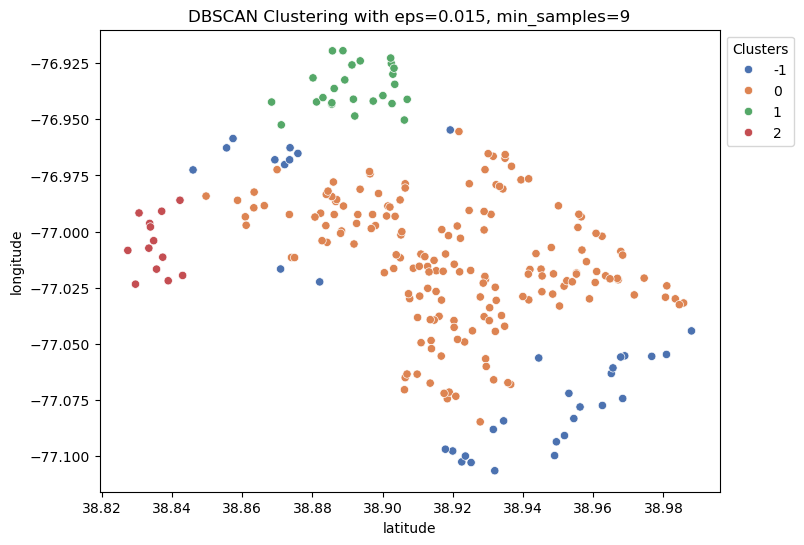

In [200]:
# selecting a different epsilon (ε) values and min_samples
#epsilon (ε) -> the min distance between two points for them to be considered neighbours 
#min_samples -> min number of points req. to be considered a dense region.

epsilons = [0.012, 0.013, 0.014, 0.015]
samples = [6,7,8,9,]
coordinates = df[['latitude', 'longitude']].to_numpy()

#looping over our chosen eps and samples
run = 0
for e in epsilons:
    for ms in samples:
        run += 1
        dbscan = DBSCAN(eps=e, min_samples=ms).fit(cordinates)
        labels = dbscan.labels_
        df['cluster'] = labels

        
        #counting amount of outliers
        num_outliers = np.count_nonzero(labels == -1)

        #
        print(f'Cluster memberships run {run} for eps: {e} and min_samples: {ms}:\n{format(labels)}')
        print(f'\nNumber of outliers identified: {num_outliers}')        

        #plotting
        plt.figure(figsize=(8, 6))  

        sns.scatterplot(data = df, x = "latitude", y = "longitude", hue = "cluster", palette="deep")
        plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
        plt.title(f'DBSCAN Clustering with eps={e}, min_samples={ms}')
        plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
        plt.show()


## 6. Visual the final DBSCAN clustering you decided upon in 5.
We decided upon 
6 for eps: 0.012 and min_samples: 6 


<Figure size 640x480 with 0 Axes>

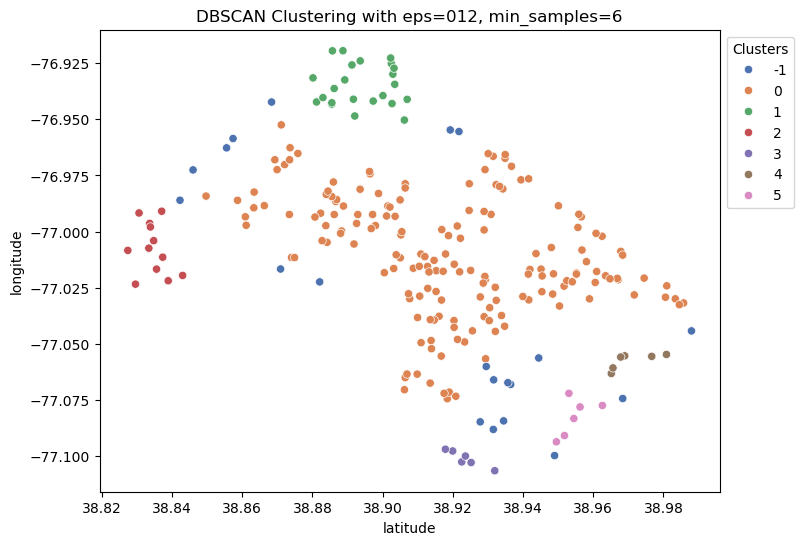

In [ ]:
dbscan = DBSCAN(eps=0.012, min_samples=6).fit(cordinates)
labels = dbscan.labels_
df['cluster'] = labels


#plotting
plt.clf()
plt.figure(figsize=(8, 6))  

sns.scatterplot(data = df, x = "latitude", y = "longitude", hue = "cluster", palette="deep")
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.title(f'DBSCAN Clustering with eps=012, min_samples=6')
plt.legend(title="Clusters", bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## 7. Calculate the Silhouette scores for the three different "best clustering" you found with the three different methods. Also use Adjusted Rand Index to compare the best ones to each other.

### Silhouette scores
So what we see here for the silhoutette score for the 3 "best" clusters:
- KMeans: 0.411
- Agglomerative Clustering: 0.377
- DBSCAN: 0.252

Note that DBSCAN performed super bad.
Kmeans was overall the "best" in the group of methods, but I we could easily have done better.
Agglomerative Clustering falls behind Kmeans.


### Adjusted Rand Index (ARI)
The Adjusted Rand Index is a measure of the similarity between two data clusterings, adjusted for the chance grouping of elements.
Ranges from -1 to 1.
1: perfect agreement.
0: random labeling
-1 worse than random labeling

- Adjusted Rand Index between KMeans and Agglomerative Clustering: 0.41926713112661257

We are closer to random labeling than a perfect aggrement, but still somewhat in the middle.


In [ ]:

silhouette_kmeans = silhouette_score(coordinates, kmeans_scaled5.labels_)
print(f"KMeans Silhouette Score: {silhouette_kmeans}")

# Compute Silhouette Score
silhouette_agg = silhouette_score(coordinates, aggmodel.labels_)
print(f"Agglomerative Clustering Silhouette Score: {silhouette_agg}")

silhouette_dbscan = silhouette_score(coordinates, dbscan.labels_)
print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")

ari = adjusted_rand_score(kmeans_scaled5.labels_, aggmodel.labels_)
print(f"ARI between KMeans and Agglomerative Cl.: {ari}")

KMeans Silhouette Score: 0.41111541380259703
Agglomerative Clustering Silhouette Score: 0.3773657323678419
DBSCAN Silhouette Score: 0.25218008349303167
Adjusted Rand Index between KMeans and Agglomerative Clustering: 0.41926713112661257
